In [1]:
import numpy as np

## Check details of 2 channel medmnist images

In [2]:
dataset_path = "/home/localssk23/.medmnist/breastmnist.npz"
data = np.load(dataset_path)
image = data['train_images'][0]
print(image.shape)
print(np.unique(image))

(28, 28)
[ 21  22  23  25  27  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 179 180 182 183 185 187 189 198 202]


In [3]:
## Check details of 3 channel medmnist images

In [4]:
dataset_path = "/home/localssk23/.medmnist/retinamnist.npz"
data = np.load(dataset_path)
image = data['train_images'][0]
print(image.shape)
print(np.unique(image))

(28, 28, 3)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168]


# Unit Tests Config

In [5]:
# import sys
import torch
from medmnist import INFO
from dataset import MNISTPerturbedDataset, MNISTGaussianDataset, MNISTRemoveDataset

import matplotlib.pyplot as plt

HOME = '/home/localssk23/'

# dataset = sys.argv[1] if len(sys.argv) > 1 else 'breastmnist'
dataset = 'retinamnist'

CONFIG = {
   "batch_size": 2,
   "num_epochs": 1,

   "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
   
   "data_path": f'{HOME}.medmnist/{dataset}.npz',
   "result_path": f'{HOME}localdp/classification/results/',

   "num_folds": 1
}

DATASET = {
    'Perturbed': MNISTPerturbedDataset,
    'Removal': MNISTRemoveDataset,
    'Gaussian': MNISTGaussianDataset
}

PERTURBATION_VALUES = {
        'original': None,
        'noisy_1pixel': 'one',
        'noisy_1%': 1,
        'noisy_5%': 5,
        'noisy_10%': 10,
        'noisy_25%': 25,
        'noisy_50%': 50,
        'noisy_75%': 75,
        'noisy_90%': 90,
        'noisy_99%': 99
    }

REMOVAL_VALUES = {
        'original': None,
        'remove_1pixel': 'one',
        'remove_1%': 1,
        'remove_5%': 5,
        'remove_10%': 10,
        'remove_25%': 25,
        'remove_50%': 50,
        'remove_75%': 75,
        'remove_90%': 90,
        'remove_99%': 99
    }

GAUSSIAN_STD_VALUES = {
    'gaussian_1': 1,
    'gaussian_5': 5,
    'gaussian_10': 10,
    'gaussian_25': 25,
    'gaussian_50': 50,
    'gaussian_75': 75,
    'gaussian_90': 90,
    'gaussian_99': 99
    }

data_flag = CONFIG['data_path'].split('/')[-1].split('.')[0]
info = INFO[data_flag]

CONFIG['num_classes'] = len(info['label'])
CONFIG['num_channels'] = info['n_channels']
CONFIG['task'] = info['task']

/home/localssk23/miniconda3/envs/cucim/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538622298/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


#train

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

device = CONFIG['device']

def lr_lambda(epoch):
    initial_lr = 1  # Initial learning rate
    if epoch < 50:
        return initial_lr  # Learning rate remains 0.001
    elif epoch < 75:
        return 0.1 * initial_lr  # Delay learning rate to 0.0001 after 50 epochs
    else:
        return 0.01 * initial_lr  # Delay learning rate to 0.00001 after 75 epochs

def train(model, train_loader, task):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_outputs = []

    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    criterion.to(CONFIG['device'])

    lr = 1
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, lr_lambda)

    for epoch in range(CONFIG['num_epochs']):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])

            if CONFIG['num_channels'] == 1:
                if total == 0:
                    plt.title('TRAIN PLOT')
                    plt.imshow(inputs[0].squeeze().cpu().numpy())
                    plt.show()
            elif CONFIG['num_channels'] == 3:
                if total == 0:
                    plt.title('TRAIN PLOT')
                    plt.imshow(inputs[0].permute(1, 2, 0).cpu().numpy())
                    plt.show()
                    
            optimizer.zero_grad()
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                loss = criterion(outputs, targets)
                
                # Calculate accuracy for multi-label
                predicted = (outputs > 0.5).int()
                correct += (predicted == targets).all(dim=1).sum().item()
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
                
                # Calculate accuracy for standard classification
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()

            total += targets.size(0)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Store targets and outputs for AUC calculation
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.detach().cpu().numpy())

    scheduler.step()

    return model


#test

In [7]:
from metrics import compute_auc

def test(model, test_loader, task):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_outputs = []
    class_correct = {}
    class_total = {}

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.float().to(CONFIG['device']), targets.to(CONFIG['device'])

            # Plot one image to confirm that the test data is indeed the original and same for each.
            if CONFIG['num_channels'] == 1:
                if total == 0:
                    plt.title('TEST PLOT')
                    plt.imshow(inputs[0].squeeze().cpu().numpy())
                    plt.show()
            elif CONFIG['num_channels'] == 3:
                if total == 0:
                    plt.title('TEST PLOT')
                    plt.imshow(inputs[0].permute(1, 2, 0).cpu().numpy())
                    plt.show()

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.float()
                predicted = (outputs > 0.5).float()
                correct += (predicted == targets).all(dim=1).sum().item()
            else:
                targets = targets.squeeze().long()
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()
                
                # Calculate class-wise accuracy
                for true, pred in zip(targets, predicted):
                    true = int(true.item())
                    pred = int(pred.item())
                    
                    if true == pred:
                        class_correct[true] = class_correct.get(true, 0) + 1
                    class_total[true] = class_total.get(true, 0) + 1

            total += targets.size(0)
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    acc = 100. * correct / total
    class_acc = {k: 100. * v / class_total[k] for k, v in class_correct.items()}

    auc = compute_auc(all_targets, all_outputs, task)

    print(f'Accuracy: {acc:.2f}%')
    print(f'AUC: {auc:.4f}')
    print('Class-wise accuracy:')
    for k, v in class_acc.items():
        print(f'Class {k}: {v:.2f}%')
    
    return acc, auc, class_acc


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


DATA: retinamnist
FOLD: 0
DATASET_STYLE: Perturbed
Loader Type: None


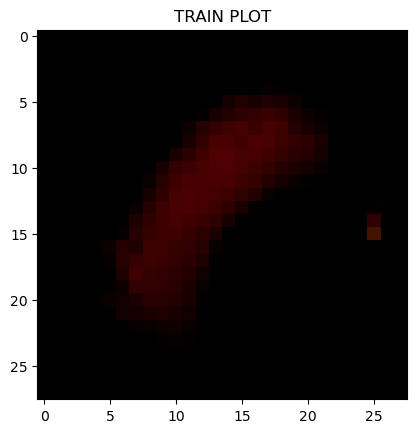

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


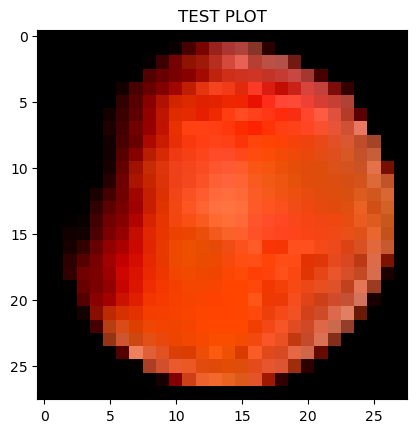

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: one


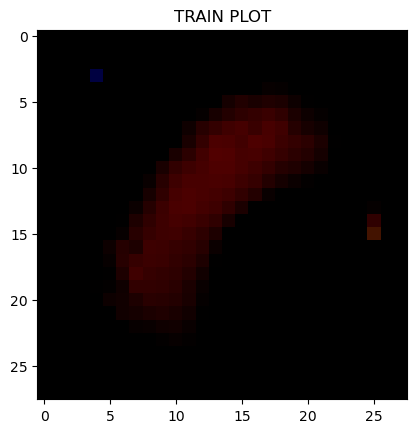

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


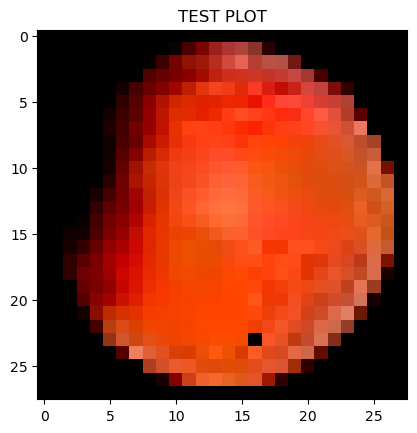

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 1


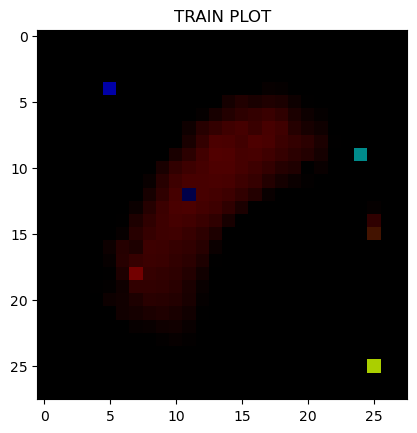

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


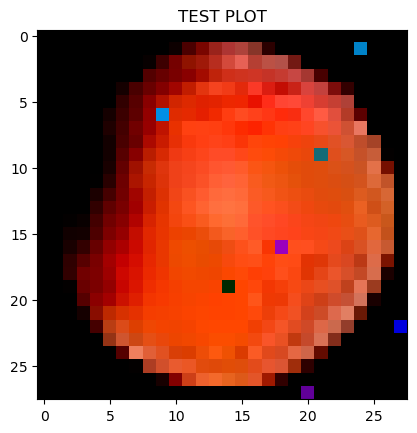

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 5


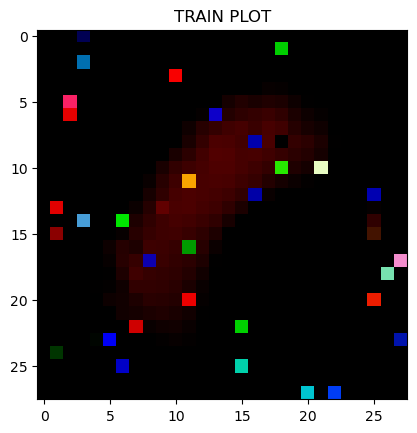

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


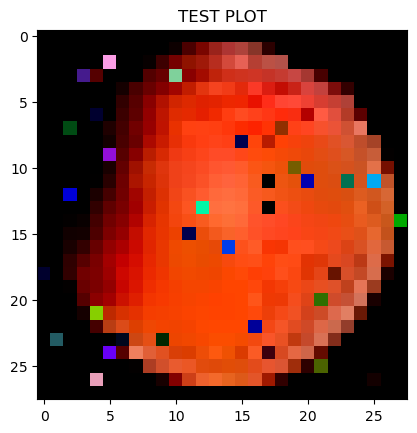

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 10


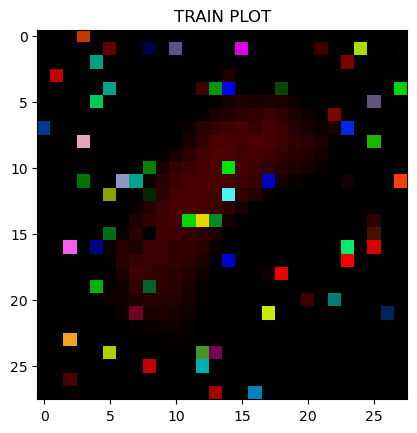

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


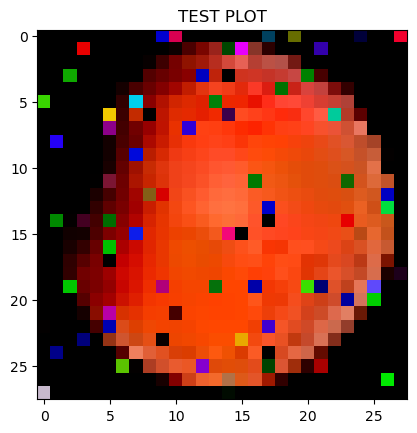

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 25


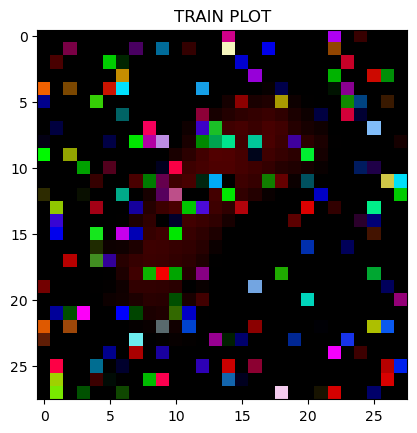

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


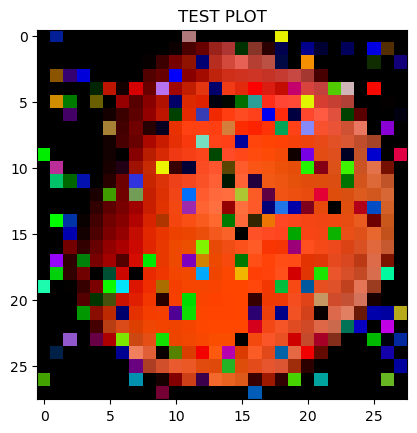

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 50


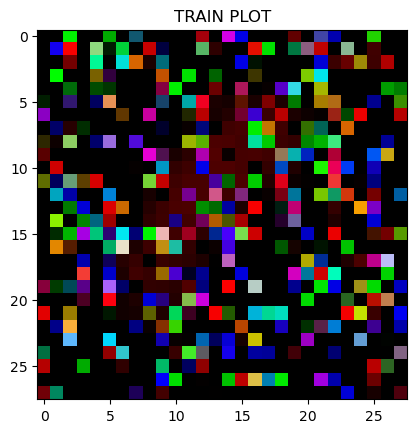

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


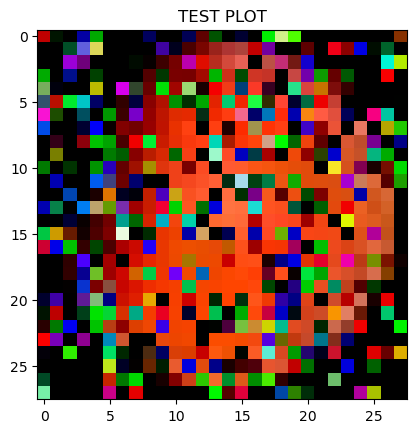

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 75


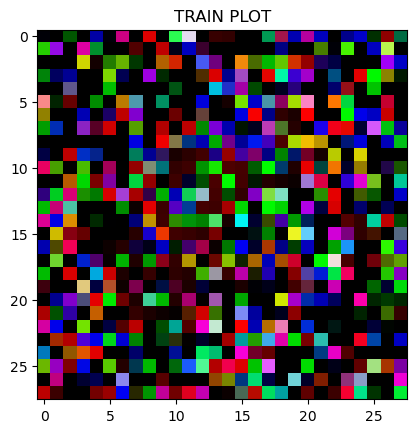

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


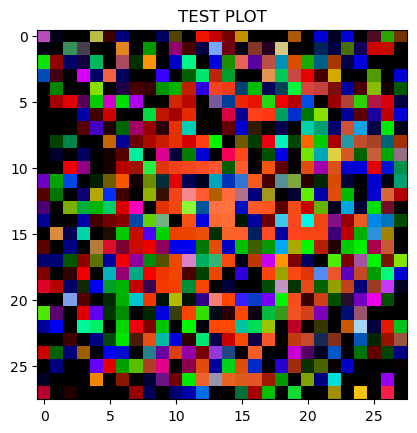

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 90


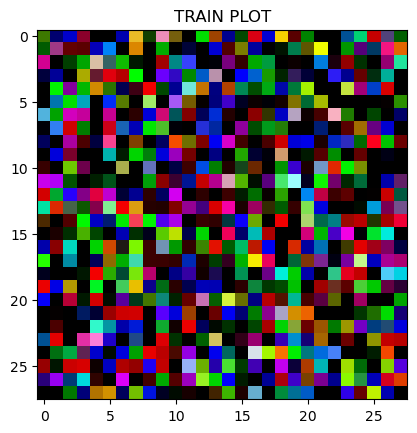

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


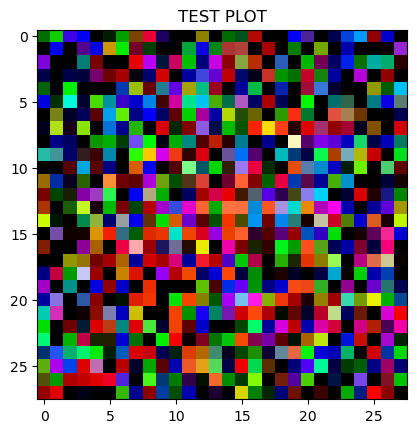

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 99


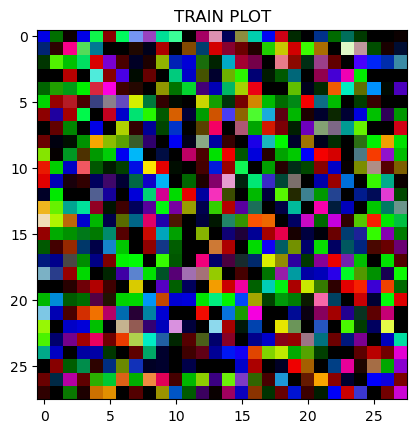

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


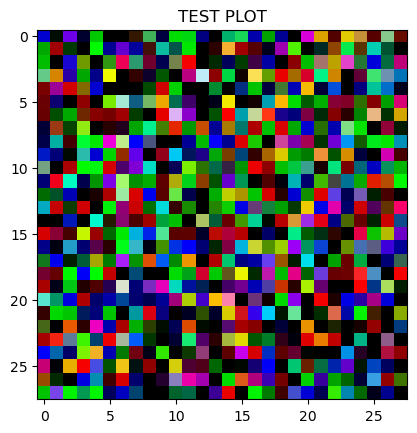

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
DATASET_STYLE: Removal
Loader Type: None


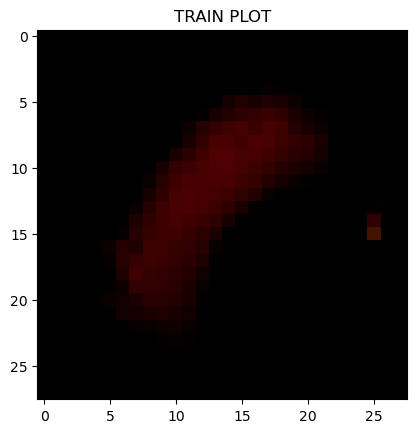

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


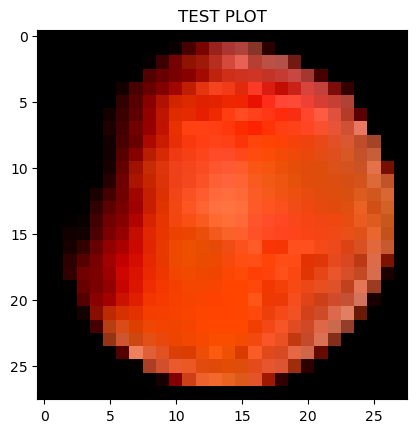

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: one


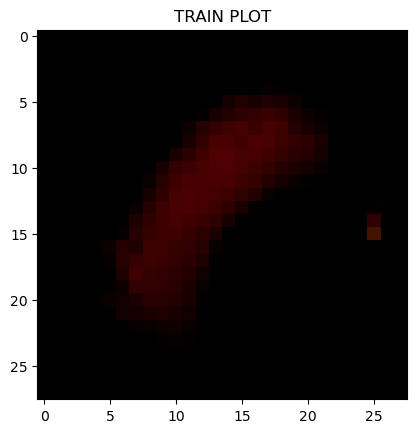

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


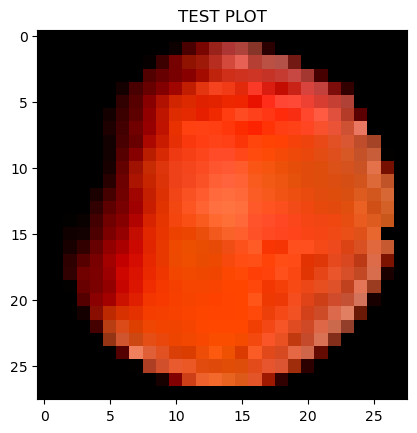

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 41.75%
AUC: 0.4861
Class-wise accuracy:
Class 0: 95.40%
Class 1: 2.17%
Loader Type: 1


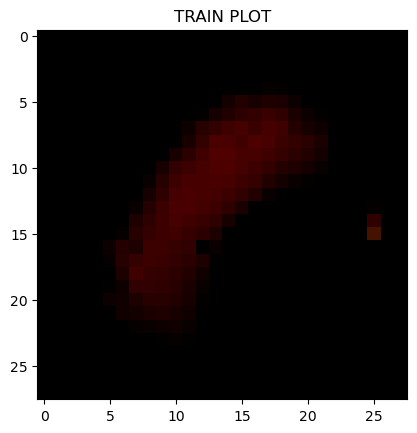

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


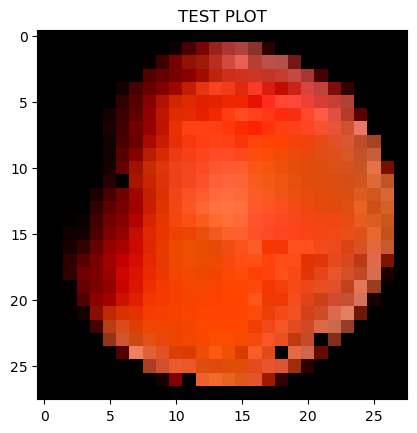

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 5


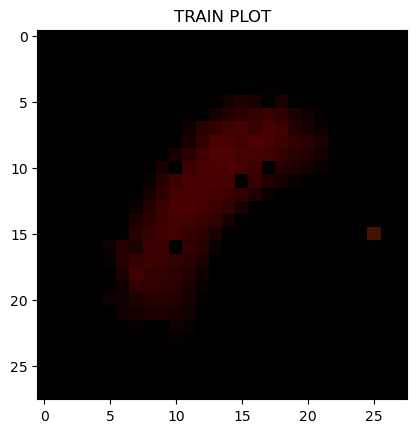

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


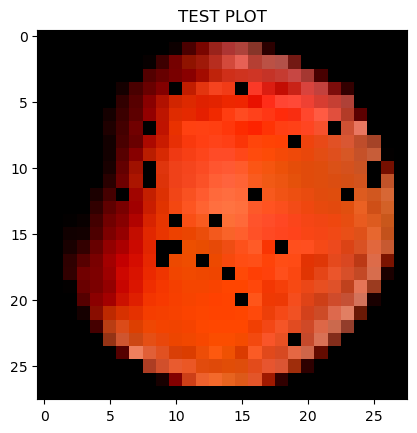

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 17.00%
AUC: 0.5037
Class-wise accuracy:
Class 3: 100.00%
Loader Type: 10


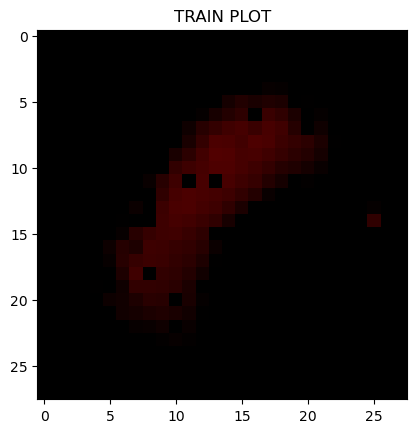

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


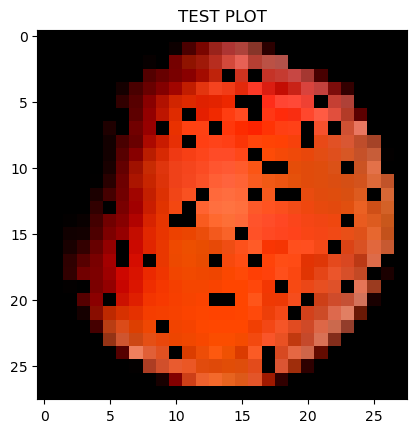

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 25


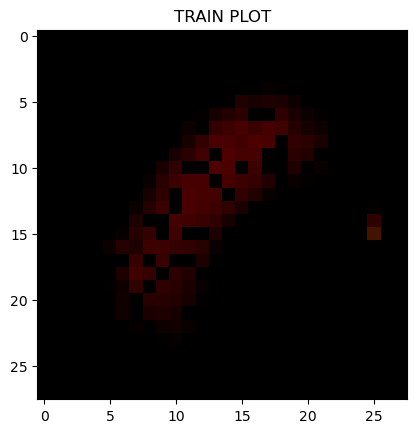

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


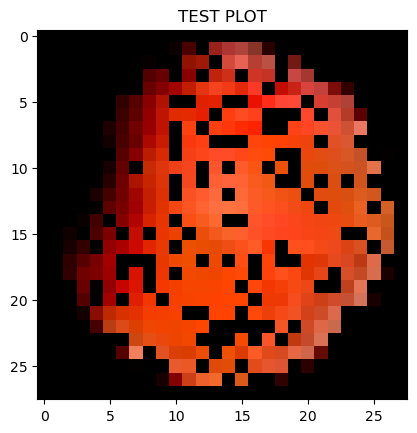

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 50


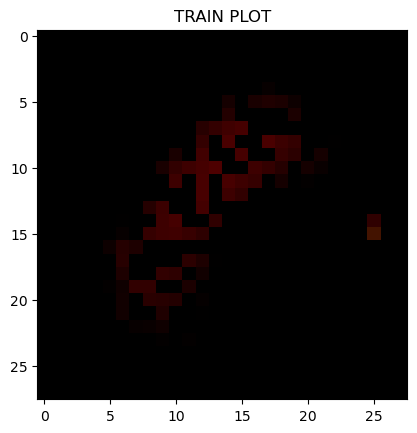

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


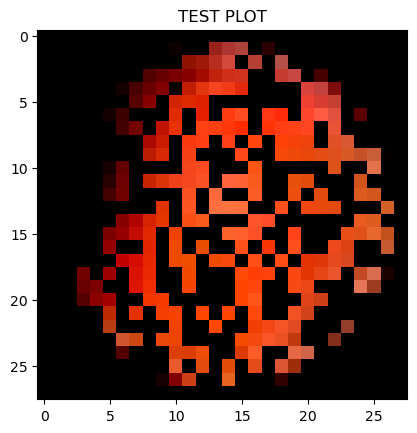

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 43.50%
AUC: 0.5000
Class-wise accuracy:
Class 0: 100.00%
Loader Type: 75


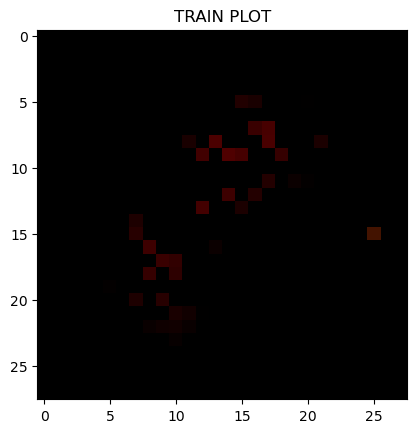

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


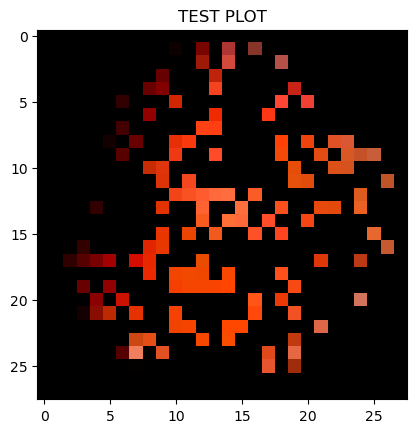

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
import warnings
# from config import CONFIG, PERTURBATION_VALUES, GAUSSIAN_STD_VALUES, DATASET

from typing import Dict

# import pandas as pd
import numpy as np

from utils import ModelResults, create_data_transform, setup_datasets
# from train import train
# from test import test
from model import Net_28

warnings.filterwarnings("ignore")

def train_and_evaluate(loaders_dict: Dict[str, Dict], dataset_style) -> Dict[str, ModelResults]:
    results = {}
    
    for loader_type in loaders_dict.values():
        print(f'Loader Type: {loader_type}')
        
        # Load and prepare data
        data = np.load(CONFIG['data_path'])
        transform = create_data_transform(CONFIG['num_channels'])
        
        # Setup model and datasets
        model = Net_28(CONFIG['num_channels'], CONFIG['num_classes']).to(CONFIG['device'])
        train_loader, test_loader = setup_datasets(data, DATASET[dataset_style], loader_type, transform)
        
        # Train and evaluate
        model_trained = train(model, train_loader, CONFIG['task'])
        acc, auc, class_acc = test(model_trained, test_loader, CONFIG['task'])
        
        results[loader_type] = ModelResults(
            accuracy=acc,
            auc=auc,
            class_acc=class_acc
        )
        
        del model, model_trained
            
    return results

def process_results(results: Dict, dataset_name: str, fold: int, dataset_style: str):
    class_results = []
    overall_results = []
    
    # Process class-wise results
    for label in range(CONFIG['num_classes']):
        result_dict = {'Dataset': dataset_name, 'Class': label}
        for loader_type, metrics in results.items():
            result_dict[f'Accuracy_{loader_type}'] = metrics.class_acc.get(label, 0)
        class_results.append(result_dict)
    
    # Process overall results
    overall_dict = {'Dataset': dataset_name}
    for loader_type, metrics in results.items():
        overall_dict[f'Overall_Accuracy_{loader_type}'] = metrics.accuracy
        overall_dict[f'Overall_AUC_{loader_type}'] = metrics.auc
    overall_results.append(overall_dict)

    # # Save results
    # pd.DataFrame(class_results).to_csv(
    #     f"{CONFIG['result_path']}{dataset_name}_class_results_fold_{fold}_{dataset_style}.csv",
    #     index=False
    # )
    # pd.DataFrame(overall_results).to_csv(
    #     f"{CONFIG['result_path']}{dataset_name}_overall_results_fold_{fold}_{dataset_style}.csv",
    #     index=False
    # )

def main(fold: int):
    dataset_name = CONFIG['data_path'].rsplit('/', 1)[-1].rsplit('.', 1)[0]
    print(f'DATA: {dataset_name}')
    print(f'FOLD: {fold}')

    for dataset_style in DATASET.keys():
        print(f'DATASET_STYLE: {dataset_style}')
        if dataset_style == 'Gaussian':
            results = train_and_evaluate(GAUSSIAN_STD_VALUES, dataset_style)
            process_results(results, dataset_name, fold, dataset_style)
        elif dataset_style == 'Perturbed':
            results = train_and_evaluate(PERTURBATION_VALUES, dataset_style)
            process_results(results, dataset_name, fold, dataset_style)
        elif dataset_style == 'Removal':
            results = train_and_evaluate(REMOVAL_VALUES, dataset_style)
            process_results(results, dataset_name, fold, dataset_style)
    print()

if __name__ == '__main__':
    for fold in range(CONFIG['num_folds']):
        main(fold)
        print()
        print()